# Generating stop CMS signals using QGANs

Intro...

## Software needed

%%capture
!pip install qiskit
!pip install pandas
!pip install sklearn
!pip install matplotlib
!pip install uproot awkward
!pip install alive-progress
!pip install qiskit[machine-learning]


## Setup

In [1]:
#pip install 'qiskit-machine-learning[torch]'

In [2]:
import uproot

import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
#%matplotlib inline

from qiskit import QuantumRegister, QuantumCircuit, BasicAer
from qiskit.circuit.library import TwoLocal

from qiskit.utils import QuantumInstance, algorithm_globals
from qiskit_machine_learning.algorithms import NumPyDiscriminator, PyTorchDiscriminator, QGAN

seed = 42
np.random.seed = seed
algorithm_globals.random_seed = seed

In [3]:
path = "/Users/ketchum/Desktop/STOP_nTuples/nTuples17_nanoAOD_v2021-10-15_test/"
process = "T2DegStop_550_520_bdt"
#process = "WJetsToLNu_HT200to400_bdt"
treename="bdttree"

myFeatures = ["Jet1Pt", "Met", "mt", "LepPt", "LepEta", "LepChg", "HT", "NbLoose","Njet", "JetHBpt", "DrJetHBLep", "JetHBDeepCSV","BDT"]
branches = ["XS","Nevt","Event","weight"]
branches.extend(myFeatures)

preSel = "(LepPt < 30) & (Met > 280) & (HT > 200) & (Jet1Pt > 110) & ((DPhiJet1Jet2 < 2.5) | (Jet2Pt < 60)) & (isTight == 1)"

processTree = uproot.open(path+process+".root:"+treename)
processDict = processTree.arrays(branches,preSel,library="np")

processDF = pd.DataFrame(processDict)
display(processDF)

,XS,Nevt,Event,weight,Jet1Pt,Met,mt,LepPt,LepEta,LepChg,HT,NbLoose,Njet,JetHBpt,DrJetHBLep,JetHBDeepCSV,BDT
0,0.347,87155.0,374123372,1.925884e-06,328.250,338.813507,32.445465,9.298288,-1.311279,1.0,385.87500,0.0,2.0,57.62500,2.036685,0.101501,-0.040352
1,0.347,87155.0,374123482,5.222981e-07,225.125,286.211121,10.798179,16.495022,-0.524292,1.0,225.12500,0.0,1.0,225.12500,3.967097,0.023834,-0.055420
2,0.347,87155.0,374123588,2.045012e-06,301.500,307.996582,20.827509,15.660460,-0.959717,-1.0,301.50000,0.0,1.0,301.50000,3.419575,0.027069,-0.033337
3,0.347,87155.0,374123626,1.607914e-06,356.250,287.643860,53.294586,4.579830,-1.618896,1.0,356.25000,0.0,1.0,356.25000,1.642915,0.020233,-0.033937
4,0.347,87155.0,374123630,7.602142e-07,272.500,280.310059,23.213980,15.694098,0.392944,1.0,444.12500,0.0,3.0,116.62500,1.480006,0.053009,-0.088034
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3446,0.347,87155.0,420187634,1.635522e-06,275.750,322.343079,147.370346,18.416704,0.764893,1.0,449.25000,1.0,3.0,124.62500,1.259977,0.156128,0.066372
3447,0.347,87155.0,420187720,2.002629e-06,403.500,413.531799,12.847763,8.921799,1.460449,-1.0,403.50000,0.0,1.0,403.50000,4.561334,0.038330,0.166194
3448,0.347,87155.0,421149834,9.760236e-07,300.750,317.044922,12.325584,19.914648,-0.663086,1.0,756.59375,0.0,5.0,227.50000,3.025809,0.060730,-0.094158
3449,0.347,87155.0,421149896,2.113200e-06,309.000,293.009735,39.851105,3.594147,0.234131,1.0,309.00000,0.0,1.0,309.00000,3.003863,0.083862,0.053850


(array([  0.,  42., 155., 165., 138., 101.,  88.,  85.,  51.,  52.,  40.,
         30.,  22.,  17.]),
 array([ 0.,  2.,  4.,  6.,  8., 10., 12., 14., 16., 18., 20., 22., 24.,
        26., 28.]),
 <BarContainer object of 14 artists>)

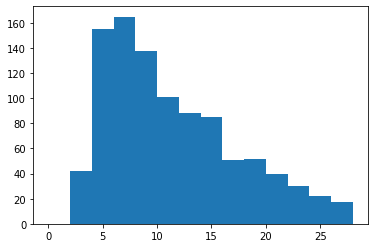

In [4]:
feature = processDict["LepPt"]
bounds = np.array([0.0, 30.0])
#feature = processDict["mt"]
#bounds = np.array([0.0, 160.0])

num_qubits = [4]
k = len(num_qubits)

n_samples=len(feature)
n_samples=1000
#n_samples=2048
#n_samples=2^num_qubits[0]
real_data = feature[:n_samples]

n_bins=round(bounds[1]/2**num_qubits[0])

binning=np.arange(bounds[0],bounds[1],n_bins)
plt.hist(real_data,binning)

In [5]:
# Set number of training epochs
# Note: The algorithm's runtime can be shortened by reducing the number of training epochs.
num_epochs = 30
# Batch size
batch_size = 50

# Initialize qGAN
qgan = QGAN(real_data, bounds, num_qubits, batch_size, num_epochs, snapshot_dir=None)
qgan.seed = seed
# Set quantum instance to run the quantum generator
quantum_instance = QuantumInstance(
    backend=BasicAer.get_backend("statevector_simulator"), seed_transpiler=seed, seed_simulator=seed
)

# Set entangler map
entangler_map = [[0, 1]]


# Set an initial state for the generator circuit as a uniform distribution
# This corresponds to applying Hadamard gates on all qubits
init_dist = QuantumCircuit(sum(num_qubits))
init_dist.h(init_dist.qubits)

# Set the ansatz circuit
ansatz = TwoLocal(int(np.sum(num_qubits)), "ry", "cz", entanglement=entangler_map, reps=1)

# Set generator's initial parameters - in order to reduce the training time and hence the
# total running time for this notebook
#init_params = [3.0, 1.0, 0.6, 1.6]

# You can increase the number of training epochs and use random initial parameters.
init_params = np.random.rand(ansatz.num_parameters_settable) * 2 * np.pi

init_params = [0.45, 3.97, 5.55, 5.92, 5.76, 1.19, 1.14, 4.46]

# Set generator circuit by adding the initial distribution infront of the ansatz
g_circuit = ansatz.compose(init_dist, front=True)

# Set quantum generator
qgan.set_generator(generator_circuit=g_circuit, generator_init_params=init_params)
# The parameters have an order issue that following is a temp. workaround
qgan._generator._free_parameters = sorted(g_circuit.parameters, key=lambda p: p.name)
# Set classical discriminator neural network
discriminator = NumPyDiscriminator(len(num_qubits))
#discriminator = PyTorchDiscriminator(len(num_qubits))
qgan.set_discriminator(discriminator)

In [6]:
# Run qGAN
result = qgan.run(quantum_instance)

In [7]:
print("Training results:")
for key, value in result.items():
    print(f"  {key} : {value}")

Training results:
  params_d : [ 0.38448079 -0.08669091  0.50338012 ...  0.07272757 -0.18884404
 -0.03819005]
  params_g : [0.47013429 3.94978738 5.57007421 5.89995852 5.78044252 1.21018784
 1.16007421 4.43995852]
  loss_d : 0.6952
  loss_g : [0.7234]
  rel_entr : 2.7449


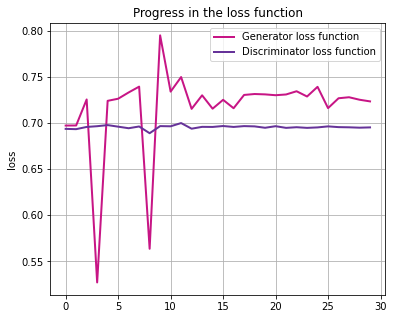

In [8]:
# Plot progress w.r.t the generator's and the discriminator's loss function
t_steps = np.arange(num_epochs)
plt.figure(figsize=(6, 5))
plt.title("Progress in the loss function")
plt.plot(
    t_steps, qgan.g_loss, label="Generator loss function", color="mediumvioletred", linewidth=2
)
plt.plot(
    t_steps, qgan.d_loss, label="Discriminator loss function", color="rebeccapurple", linewidth=2
)
plt.grid()
plt.legend(loc="best")
plt.ylabel("loss")
plt.show()

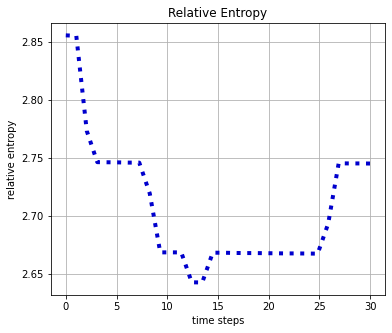

In [9]:
# Plot progress w.r.t relative entropy
plt.figure(figsize=(6, 5))
plt.title("Relative Entropy")
plt.plot(
    np.linspace(0, num_epochs, len(qgan.rel_entr)), qgan.rel_entr, color="mediumblue", lw=4, ls=":"
)
plt.grid()
plt.xlabel("time steps")
plt.ylabel("relative entropy")
plt.show()

In [10]:
real_data_final = np.round(real_data)
real_data_final = real_data_final[real_data_final <= bounds[1]]
temp = []
#for i in range(int(bounds[0]),int(bounds[1]),n_bins):
for i in range(int(bounds[1] + 1)):
    temp += [np.sum(real_data_final == i)]
real_data_final = np.array(temp / sum(temp))

In [11]:
samples_g, prob_g = qgan.generator.get_output(qgan.quantum_instance, shots=10000)
samples_g = np.array(samples_g)
samples_g = samples_g.flatten()
num_bins = len(prob_g)

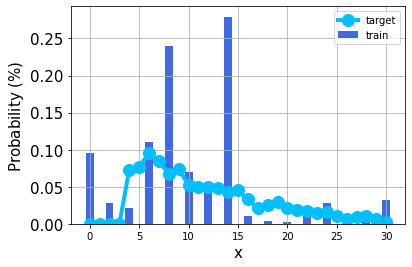

In [12]:
plt.bar(samples_g, prob_g, label="train", color="royalblue")
#plt.xticks(samples_g, size=15, rotation=90)
plt.yticks(size=15)
plt.grid()
plt.xlabel("x", size=15)
plt.ylabel("Probability ($\%$)", size=15)
plt.plot(
    real_data_final,
    "-o",
    color="deepskyblue",
    label="target",
    linewidth=4,
    markersize=12,
)
plt.legend(loc="best")
plt.show()

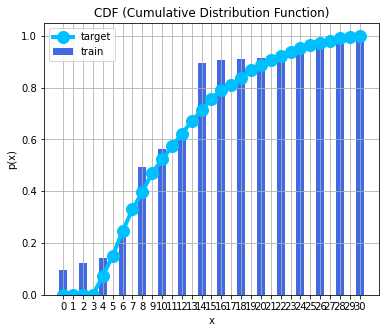

In [13]:
plt.figure(figsize=(6, 5))
plt.title("CDF (Cumulative Distribution Function)")

plt.bar(samples_g, np.cumsum(prob_g), color="royalblue", width=0.8, label="train")
plt.plot(
    np.cumsum(real_data_final), "-o", label="target", color="deepskyblue", linewidth=4, markersize=12
)
plt.xticks(np.arange(min(samples_g), max(samples_g) + 1, 1.0))
plt.grid()
plt.xlabel("x")
plt.ylabel("p(x)")
plt.legend(loc="best")
plt.show()

In [14]:
import qiskit.tools.jupyter

%qiskit_version_table
%qiskit_copyright